# Batch Regression models

In [170]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_absolute_error

In [4]:
#Define ticker
SP500 = '^GSPC'
CAC40 = '^FCHI'
Nikkei225 = '^N225'

#Recover Data
SP500_ticker = yf.Ticker(SP500)
CAC40_ticker = yf.Ticker(CAC40)
Nikkei225_ticker = yf.Ticker(Nikkei225)

#Recover prices
SP500_data = SP500_ticker.history(period='10Y')
CAC40_data = CAC40_ticker.history(period='10Y')
Nikkei225_data = Nikkei225_ticker.history(period='10Y')

In [5]:
SP500_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-01-14 00:00:00-05:00,1472.050049,1472.050049,1465.689941,1470.680054,3003010000,0.0,0.0
2013-01-15 00:00:00-05:00,1470.670044,1473.310059,1463.760010,1472.339966,3135350000,0.0,0.0
2013-01-16 00:00:00-05:00,1472.329956,1473.959961,1467.599976,1472.630005,3384080000,0.0,0.0
2013-01-17 00:00:00-05:00,1472.630005,1485.160034,1472.630005,1480.939941,3706710000,0.0,0.0
2013-01-18 00:00:00-05:00,1480.949951,1485.979980,1475.810059,1485.979980,3795740000,0.0,0.0


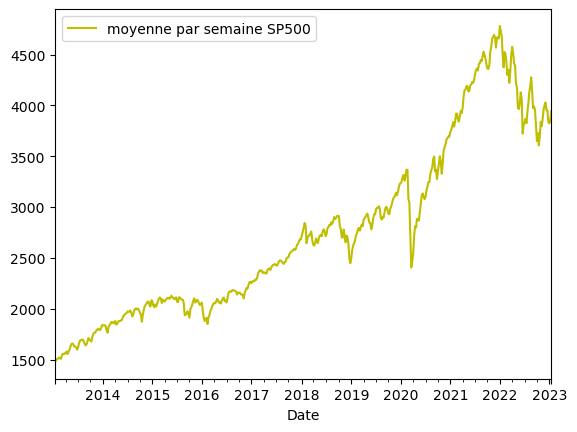

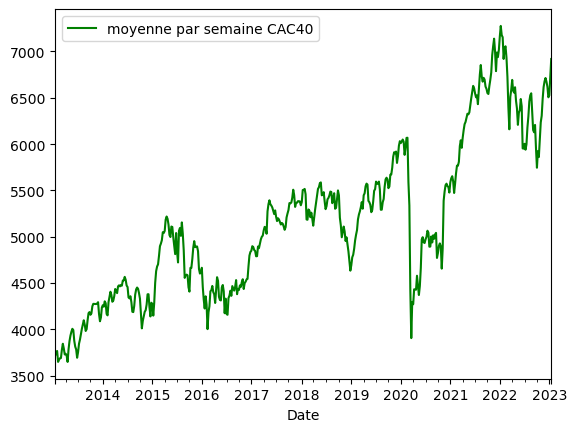

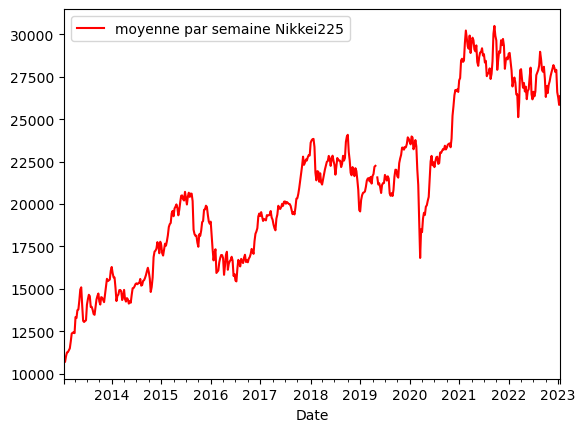

In [6]:
SP = SP500_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])
CAC = CAC40_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])
Nikkei = Nikkei225_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])

plt.figure()
SP['mean'].plot(label='moyenne par semaine SP500', c='y')
plt.legend()

plt.figure()
CAC['mean'].plot(label='moyenne par semaine CAC40', c='g')
plt.legend()

plt.figure()
Nikkei['mean'].plot(label='moyenne par semaine Nikkei225', c ='r')
plt.legend()

plt.show()

# Functions

In [7]:
predict_every = 120
predict_during = 30

In [327]:
def train_test(df,predict_every,predict_during, diff=1):
    list_df_train = []
    list_df_test = []
    nb_dataset = len(df) // predict_every
    df['label'] = df['Close'].shift(-diff)
    for i in range(1,nb_dataset+1):
        train_i = df[:i*predict_every]
        list_df_train.append(train_i)
        test_i = df['Close'][i*predict_every:i*predict_every+predict_during]
        list_df_test.append(test_i)
    
    return list_df_train, list_df_test

In [337]:
list_SP500_train, list_SP500_test = train_test(SP500_data,predict_every,predict_during)

In [338]:
for train,test in zip(list_SP500_train, list_SP500_test):
    print(train.shape,test.shape)

(120, 8) (30,)
(240, 8) (30,)
(360, 8) (30,)
(480, 8) (30,)
(600, 8) (30,)
(720, 8) (30,)
(840, 8) (30,)
(960, 8) (30,)
(1080, 8) (30,)
(1200, 8) (30,)
(1320, 8) (30,)
(1440, 8) (30,)
(1560, 8) (30,)
(1680, 8) (30,)
(1800, 8) (30,)
(1920, 8) (30,)
(2040, 8) (30,)
(2160, 8) (30,)
(2280, 8) (30,)
(2400, 8) (30,)


In [339]:
list_SP500_train[0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,label
Date,,,,,,,,
2013-01-14 00:00:00-05:00,1472.050049,1472.050049,1465.689941,1470.680054,3003010000,0.0,0.0,1472.339966
2013-01-15 00:00:00-05:00,1470.670044,1473.310059,1463.760010,1472.339966,3135350000,0.0,0.0,1472.630005
2013-01-16 00:00:00-05:00,1472.329956,1473.959961,1467.599976,1472.630005,3384080000,0.0,0.0,1480.939941
2013-01-17 00:00:00-05:00,1472.630005,1485.160034,1472.630005,1480.939941,3706710000,0.0,0.0,1485.979980
2013-01-18 00:00:00-05:00,1480.949951,1485.979980,1475.810059,1485.979980,3795740000,0.0,0.0,1492.560059
...,...,...,...,...,...,...,...,...
2013-06-28 00:00:00-04:00,1611.119995,1615.939941,1601.060059,1606.280029,4977190000,0.0,0.0,1614.959961
2013-07-01 00:00:00-04:00,1609.780029,1626.609985,1609.780029,1614.959961,3104690000,0.0,0.0,1614.079956
2013-07-02 00:00:00-04:00,1614.290039,1624.260010,1606.770020,1614.079956,3317130000,0.0,0.0,1615.410034


In [340]:
def plot_results(pred):
    # nombre de lignes et de colonnes de la grille de tracé
    n_rows = 5
    n_cols = 4

    # créer une figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))
    
    maes = []
    # itérer à travers les dataframes
    for i,df in enumerate(pred):
        # calculer les indices de ligne et de colonne pour tracer le dataframe
        row = i // n_cols
        col = i % n_cols
        # tracer le dataframe
        mae = mean_absolute_error(df['Close'],df[0])
        maes.append(mae)
        df.plot(ax=axs[row][col], title=f'{mae}')
        
    print('Mean Absolute Error Total :', np.mean(maes))

    # afficher la figure
    plt.show()

## Holt-Winters Exponential Smoothing

In [341]:
from statsmodels.tsa.api import ExponentialSmoothing

In [342]:
def HoltWinters(list_train,list_test):
    list_pred = []
    for train_data, test_data in zip(list_train,list_test):
        hw = ExponentialSmoothing(np.array(train_data['Close'])).fit()
        hw_pred = hw.forecast(predict_during)
        series_pred = pd.Series(hw_pred, index = test_data.index)
        list_pred.append(pd.concat([test_data,series_pred], axis=1))
    
    return list_pred

In [343]:
hw_SP500_pred = HoltWinters(list_SP500_train,list_SP500_test)

In [344]:
hw_SP500_pred[0]

,Close,0
Date,,
2013-07-08 00:00:00-04:00,1640.459961,1629.019731
2013-07-09 00:00:00-04:00,1652.319946,1629.019731
2013-07-10 00:00:00-04:00,1652.619995,1629.019731
2013-07-11 00:00:00-04:00,1675.020020,1629.019731
2013-07-12 00:00:00-04:00,1680.189941,1629.019731
2013-07-15 00:00:00-04:00,1682.500000,1629.019731
2013-07-16 00:00:00-04:00,1676.260010,1629.019731
2013-07-17 00:00:00-04:00,1680.910034,1629.019731
2013-07-18 00:00:00-04:00,1689.369995,1629.019731


Mean Absolute Error Total : 71.17652326012367


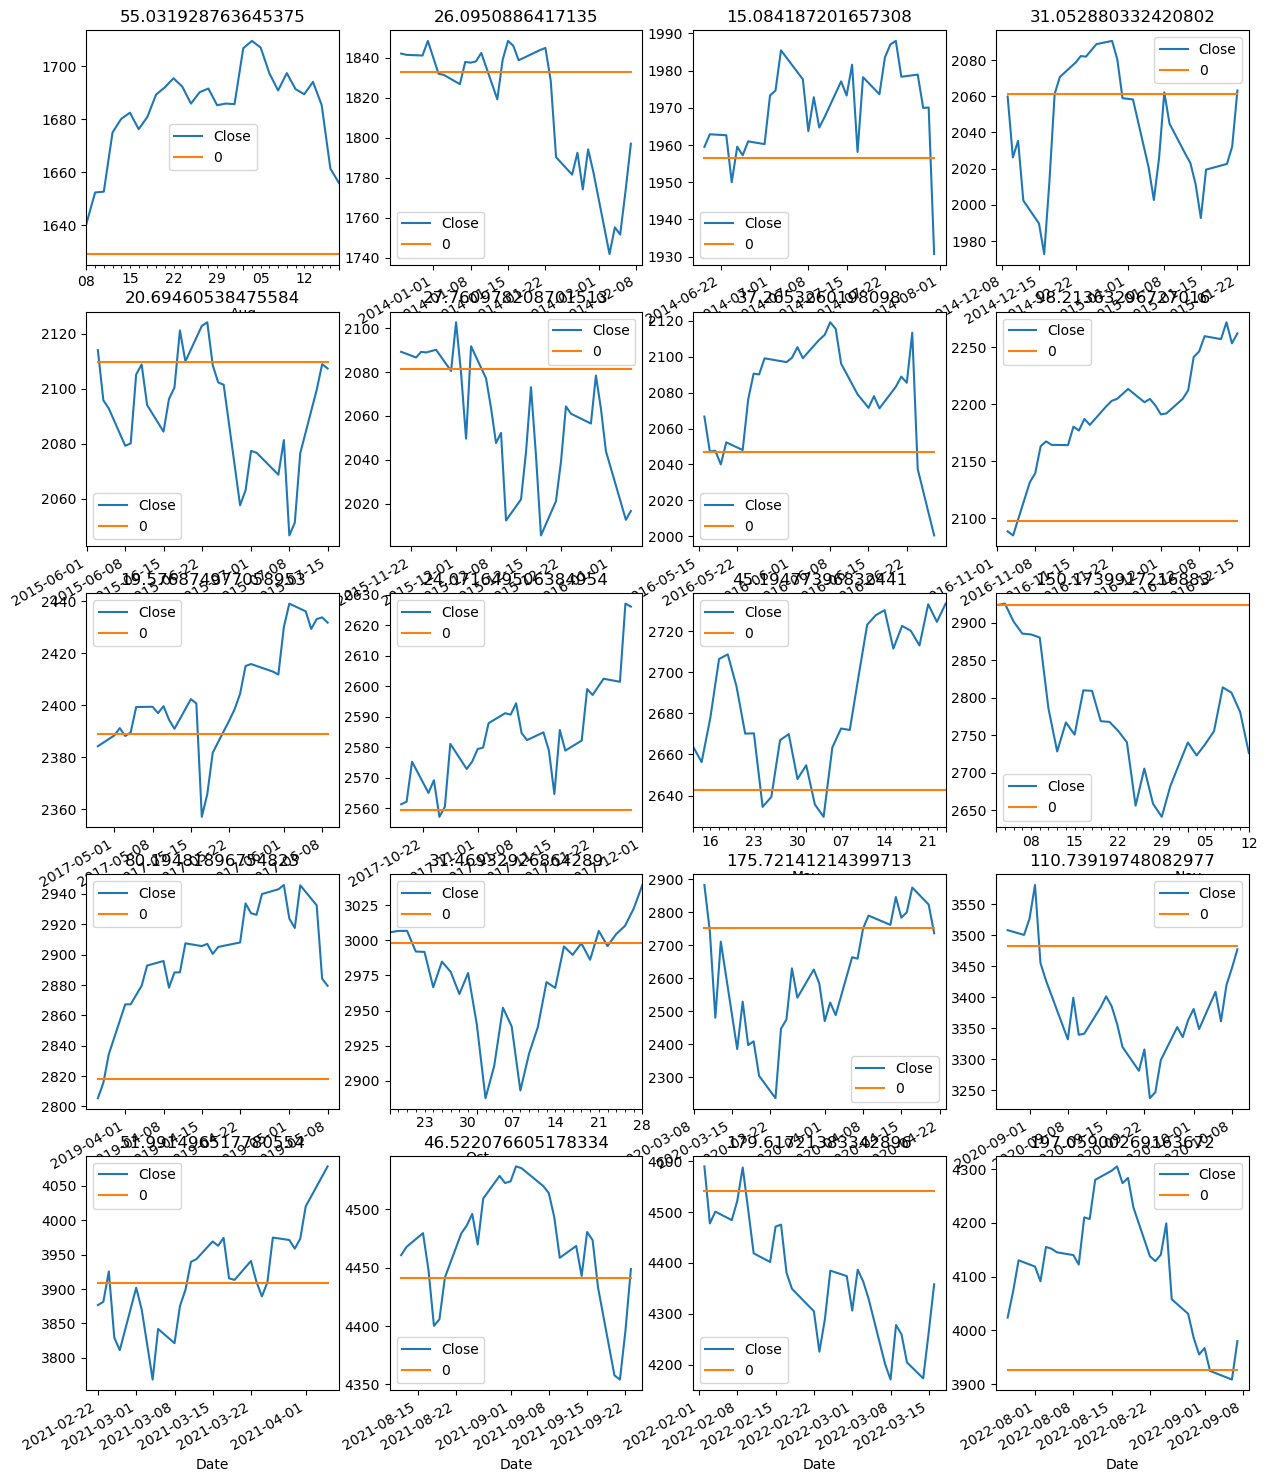

In [345]:
plot_results(hw_SP500_pred)

## SARIMAX

In [276]:
from statsmodels.tsa.statespace.sarimax import *

In [277]:
def Snarimax(list_train,list_test):
    list_pred = []
    for train_data, test_data in zip(list_train,list_test):
        snarimax = SARIMAX(np.array(train_data['Close']), order=(1,1,1), seasonal_order=(0,1,1,24)).fit()
        Sarimax_pred = snarimax.forecast(predict_during)
        series_pred = pd.Series(Sarimax_pred, index = test_data.index)
        list_pred.append(pd.concat([test_data,series_pred], axis=1))
    
    return list_pred

In [278]:
snarimax_SP500_pred = Snarimax(list_SP500_train,list_SP500_test)

C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [279]:
snarimax_SP500_pred[0]

,Close,0
Date,,
2013-07-08 00:00:00-04:00,1640.459961,1634.401320
2013-07-09 00:00:00-04:00,1652.319946,1632.960870
2013-07-10 00:00:00-04:00,1652.619995,1621.483951
2013-07-11 00:00:00-04:00,1675.020020,1633.221842
2013-07-12 00:00:00-04:00,1680.189941,1637.878601
2013-07-15 00:00:00-04:00,1682.500000,1642.334579
2013-07-16 00:00:00-04:00,1676.260010,1639.847977
2013-07-17 00:00:00-04:00,1680.910034,1638.472633
2013-07-18 00:00:00-04:00,1689.369995,1644.380582


Mean Absolute Error Total : 72.54283474186178


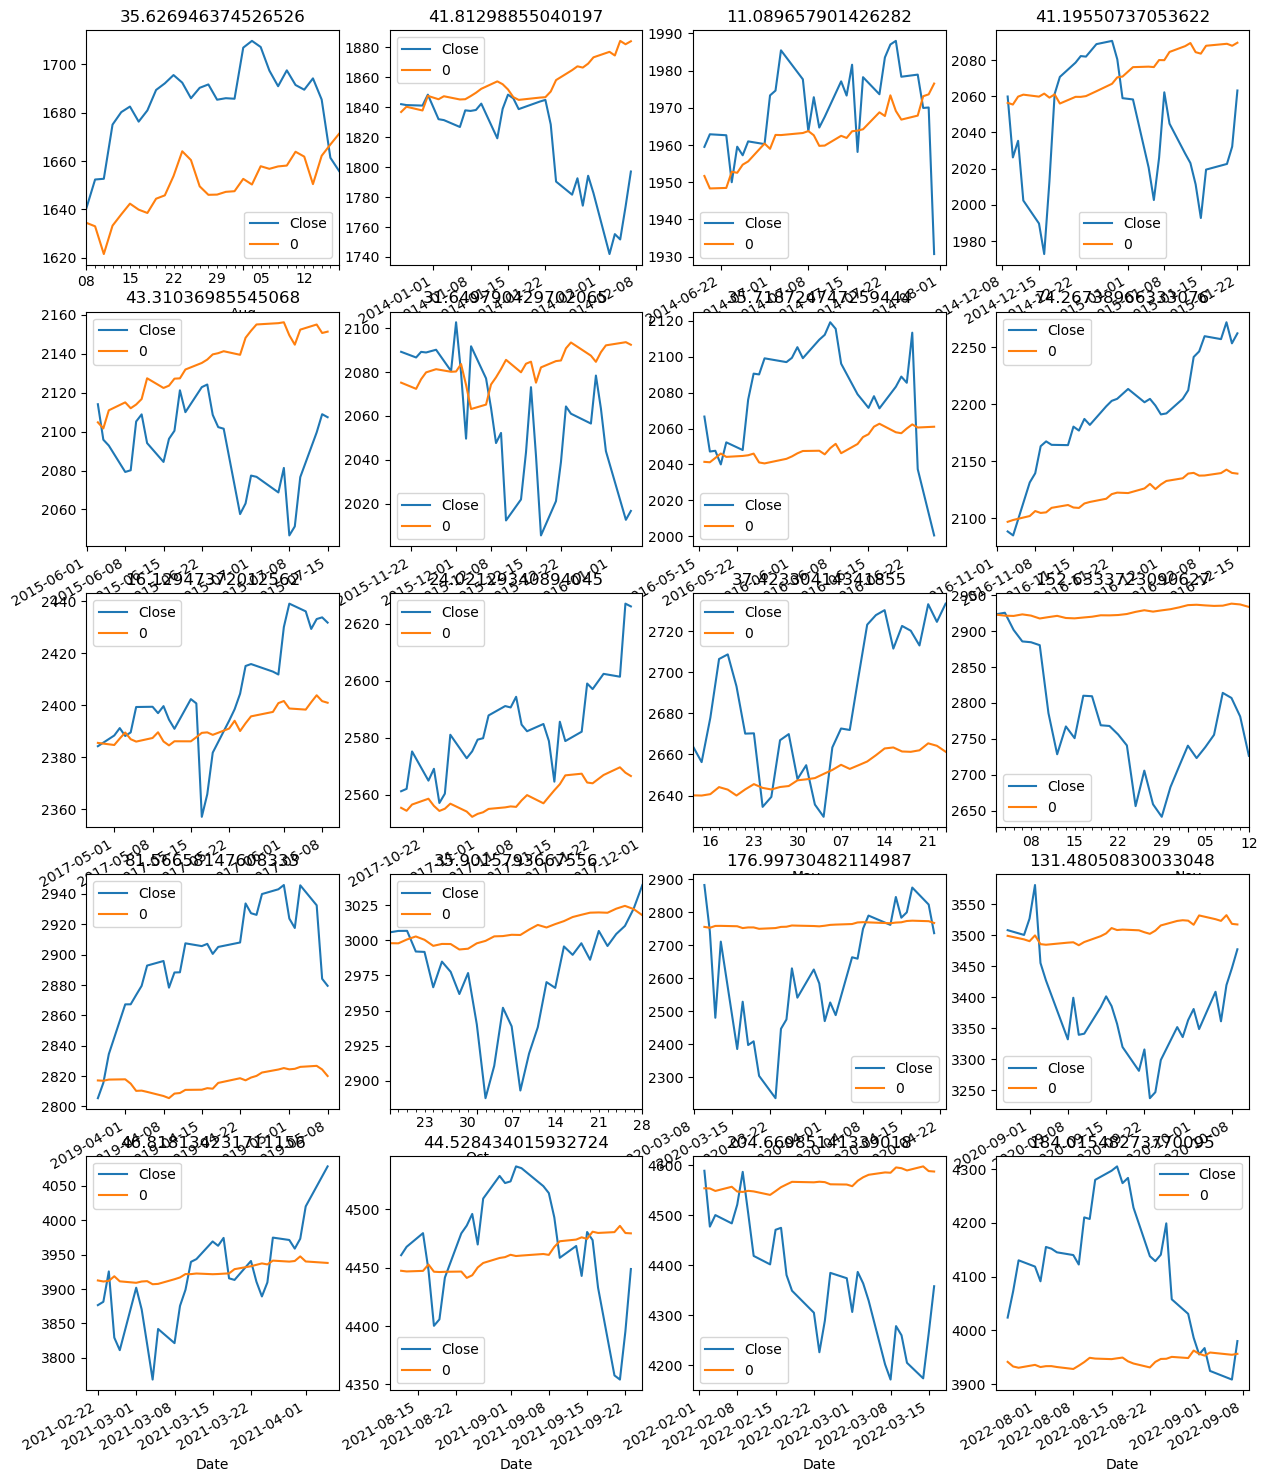

In [280]:
plot_results(snarimax_SP500_pred)

# Rolling Linear Regression

In [329]:
list_SP500_train, list_SP500_test = train_test(SP500_data,predict_every,predict_during,diff=predict_during)

In [347]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def RollingRegression(list_train,list_test,predict_during):
    list_pred = []
    for train_data, test_data in zip(list_train,list_test):
        label = train_data['label']
        train_data1 = train_data.copy().drop(columns=['Open','Dividends', 'Stock Splits','label'])
        scaler = StandardScaler()
        scaler.fit(train_data1)
        train_data1 = scaler.transform(train_data1)
        
        lr = LinearRegression()
        lr.fit(train_data1,label)
        
        roll_reg_pred = lr.predict(train_data1[-predict_during:])
        series_pred = pd.Series(roll_reg_pred, index = test_data.index)
        list_pred.append(pd.concat([test_data,series_pred], axis=1))
        
    return list_pred

In [ ]:

        series_pred = pd.Series(Sarimax_pred, index = test_data.index)
        list_SP500_pred.append(pd.concat([test_data,series_pred], axis=1))

In [354]:
rollreg_SP500_pred = RollingRegression(list_SP500_train,list_SP500_test,predict_during)

Mean Absolute Error Total : 113.3106764600866


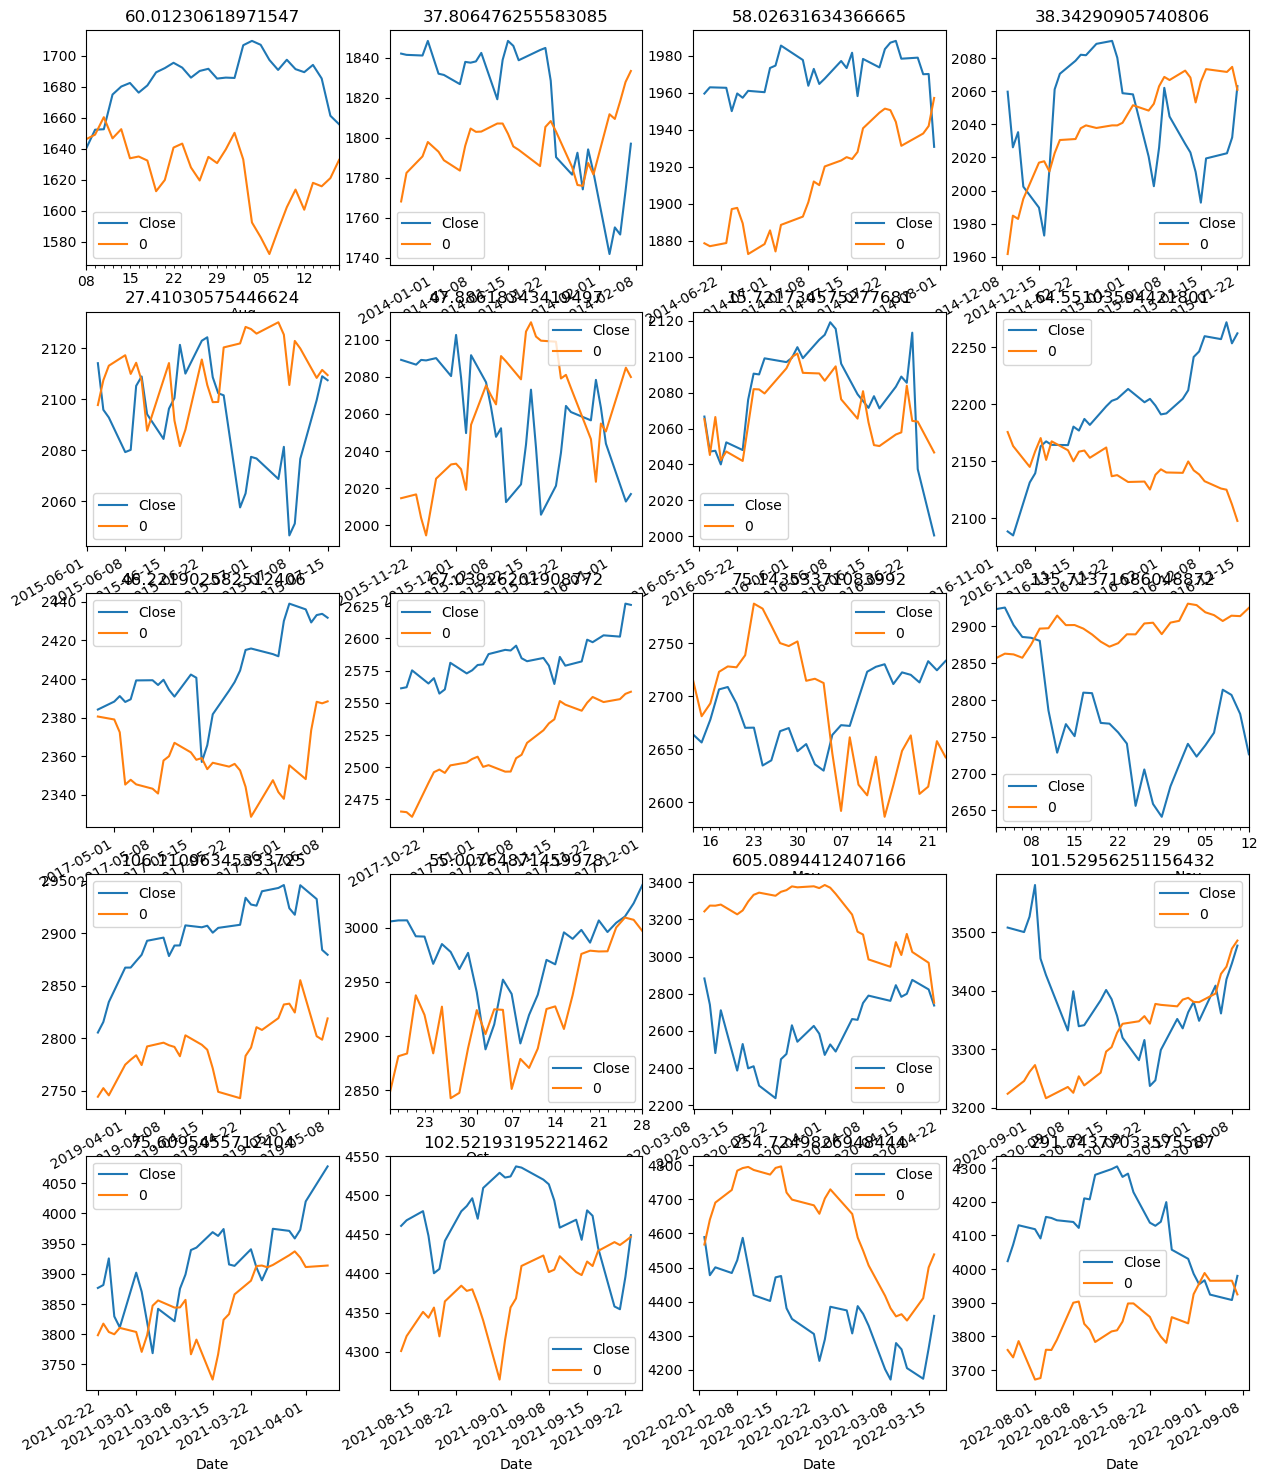

In [355]:
plot_results(rollreg_SP500_pred)